<a href="https://colab.research.google.com/github/Ayesha-Imr/Graph-RAG-Automation-ApertureDB-Gemini/blob/main/Notebooks/GraphRAG_with_ApertureDB_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphRAG with ApertureDB: Part 2 - Implementing and Evaluating Graph RAG

Welcome to the second part of our tutorial! In [Part 1](https://colab.research.google.com/drive/1AckPhZUWFC22MNyZgWE5Zb5q9WEKRSgx?usp=drive_open#scrollTo=X0pWcgojnygK), we successfully built a knowledge graph from a PDF document and ingested it into ApertureDB. Now, we'll put that graph to work.

Our goal is to build a Q&A system using two different Retrieval-Augmented Generation (RAG) methods and compare their performance.

1.  **Vanilla RAG:** A standard approach using pure vector search to find relevant information.
2.  **Graph RAG:** A more advanced method that leverages the connections within our knowledge graph to find richer, more contextual information.

## 1. Environment Setup

First, let's install the necessary libraries and set up our clients for [ApertureDB](https://www.aperturedata.io/) and Google's [Gemini](https://ai.google.dev/gemini-api/docs/models) models. We'll be using Gemini for both embedding our queries and for generating the final answers.

In [1]:
!pip install -q  aperturedb google-genai

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.0/141.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.8 MB/s eta 0:00:00


In [6]:
# Core imports
import os
import json
import time
from typing import Dict, List, Any
from tqdm import tqdm
import numpy as np

# Data models and utilities
from pydantic import BaseModel, Field
from google.colab import userdata, files
from aperturedb.CommonLibrary import create_connector
from IPython.display import HTML, display
import pprint
from google import genai
from google.genai import types, errors

Set up the API keys. You can get a Google API key [here](https://aistudio.google.com/apikey).

In [104]:
db_host = userdata.get("APERTUREDB_HOST")
db_key = userdata.get("APERTUREDB_KEY")
google_api_key = userdata.get("GOOGLE_API_KEY")

Connect to the ApertureDB client.

In [4]:
client = client = create_connector(
          key=db_key
        )

## 2. Defining the Retrieval Logic

The core of any RAG system is the retrieval mechanism. Here, we define the main functions for both of our RAG approaches.

First, lets define the confgurations for our vector search system. We use Google's [`gemini-embedding-001`](https://ai.google.dev/gemini-api/docs/embeddings) embedding model here, with dimensions configured to 768 - same as our document embeddings' dimensions. It is necessary for these dimensions to match.

In [106]:
GEMINI_MODEL_NAME = "gemini-embedding-001"
EMBEDDING_DIMENSIONS = 768
gemini_client = genai.Client(api_key=google_api_key)
DESCRIPTOR_SET_NAME = "entity_embeddings_gemini"

Both of our RAG methods will start with a vector search to find initial, semantically relevant entities. This function takes a user's query, embeds it using the `gemini-embedding-001` model, and performs a K-Nearest Neighbor (KNN) search in ApertureDB to find the most similar entities in our knowledge base.

ApertureDB's ability to chain commands is powerful here: we first `FindDescriptor` to get the top K vectors, then immediately find the `Entity` connected to each vector via the `has_embedding` relationship, all in a single query.

In [8]:
def find_semantic_entry_points(query_text: str, k: int, client, gemini_client) -> List[Dict[str, Any]]:
    """
    Finds the top K most semantically relevant entities in the knowledge graph
    based on a user query using vector search and graph traversal.
    Uses Gemini for generating the embedding of the query.
    """
    # Create Gemini embedding config
    embed_cfg = types.EmbedContentConfig(
        output_dimensionality=EMBEDDING_DIMENSIONS,
        task_type="QUESTION_ANSWERING",  # since it's will be used for Q&A. RETRIEVAL_QUERY can also be used here.
    )

    # Get embedding from Gemini
    result = gemini_client.models.embed_content(
        model=GEMINI_MODEL_NAME,
        contents=[query_text],
        config=embed_cfg,
    )

    # Extract embedding
    query_embedding = result.embeddings[0].values
    query_embedding_bytes = np.array(query_embedding, dtype=np.float32).tobytes()

    # Execute a FindDescriptor KNN query and traverse to linked entities
    query = [
        {
            "FindDescriptor": {
                "set": DESCRIPTOR_SET_NAME,
                "k_neighbors": k,
                "distances": True,
                "blobs": False,
                "results": {
                    "all_properties": True
                },
                "_ref": 1,
            }
        },
        {
            "FindEntity": {
                "is_connected_to": {
                    "ref": 1,
                    "connection_class": "has_embedding",
                },
                "results": {
                    "all_properties": True
                },
            }
        },
    ]

    response, _ = client.query(query, [query_embedding_bytes])

    # Extract results
    descriptor_results = response[0].get("FindDescriptor", {}).get("entities", [])
    entity_results = response[1].get("FindEntity", {}).get("entities", [])

    # Map descriptor -> class, entity -> full data
    id_to_class_map = {
        d.get('source_entity_id'): d.get('source_entity_class')
        for d in descriptor_results
    }
    id_to_entity_data_map = {
        e.get('id'): e
        for e in entity_results
    }

    enriched_entities = []
    for descriptor_item in descriptor_results:
        entity_id = descriptor_item.get('source_entity_id')
        if entity_id in id_to_entity_data_map:
            entity_data = id_to_entity_data_map[entity_id].copy()
            entity_data['class'] = id_to_class_map.get(entity_id)
            enriched_entities.append(entity_data)

    return enriched_entities

 A helper function to format retreived entities into a string to be passed as context into an LLM prompt.

In [9]:
def _format_entity_properties(entity: Dict[str, Any]) -> str:
    """Helper to format entity properties into a string."""
    formatted_props = []
    entity_name = entity.get('name', f"Entity_{entity.get('id', 'Unknown')}")
    entity_class = entity.get('class', 'Unknown')

    formatted_props.append(f"Entity: '{entity_name}' (Class: '{entity_class}', ID: {entity.get('id', 'N/A')})")

    for key, value in entity.items():
        if not key.startswith('_') and key not in ['name', 'class', 'id', '_uniqueid']:
            if isinstance(value, (dict, list)):
                value_str = str(value)
            else:
                value_str = str(value)
            formatted_props.append(f"  - {key}: {value_str}")
    return "\n".join(formatted_props)

This is the key component of Graph RAG. Starting from the initial entities, this function traverses the graph outwards for a set number of `hops`, collecting connected entities and their relationships to build a rich, interconnected context.

In [10]:
def build_traversal_context(start_entities: List[Dict[str, Any]], max_hops: int, max_entities: int, client) -> str:
    """
    Performs a bounded BFS graph traversal from start_entities, collecting
    and formatting entities and connections into a context string.
    """
    context_strings: List[str] = []

    collected_entities: Dict[int, Dict[str, Any]] = {}
    collected_connections: List[Dict[str, Any]] = []

    explored_entity_ids: set = set()

    frontier_ids_for_current_hop: List[int] = []

    # Initialize the frontier with the starting entities
    frontier_ids_for_current_hop: List[int] = []

    for entity in start_entities:
        entity_id = entity.get("id")
        if entity_id is None or entity_id in explored_entity_ids:
            continue

        # Add the starting entity to the context and mark as explored
        context_strings.append(_format_entity_properties(entity))
        explored_entity_ids.add(entity_id)
        frontier_ids_for_current_hop.append(entity_id)
        collected_entities[entity_id] = entity

        if len(explored_entity_ids) >= max_entities:
            break

    # Perform BFS traversal up to max_hops
    for hop in range(1, max_hops + 1):
        if not frontier_ids_for_current_hop or len(explored_entity_ids) >= max_entities:
            break

        all_connections_this_hop: List[Dict[str, Any]] = []
        queries_for_this_hop = []
        # Build queries to find connections for entities in the current frontier
        for i, entity_id in enumerate(frontier_ids_for_current_hop):
            ref_id = i + 1
            entity_class = collected_entities[entity_id].get('class', 'Unknown')
            queries_for_this_hop.extend([
                {"FindEntity": {"with_class": entity_class, "constraints": {"id": ["==", entity_id]}, "_ref": ref_id}},
                {"FindConnection": {"src": ref_id, "results": {"all_properties": True}}},
                {"FindConnection": {"dst": ref_id, "results": {"all_properties": True}}}
            ])

        # Execute the queries to find connections
        responses, _ = client.query(queries_for_this_hop)

        # Collect unique connections found in this hop
        conn_uids_seen = set()
        for resp_block in responses:
            if "FindConnection" in resp_block and resp_block["FindConnection"].get("connections"):
                for conn in resp_block["FindConnection"]["connections"]:
                    if conn["_uniqueid"] not in conn_uids_seen:
                        all_connections_this_hop.append(conn)
                        conn_uids_seen.add(conn["_uniqueid"])

        collected_connections.extend(all_connections_this_hop)

        # Map entity IDs to their classes from the connections
        id_to_class_map = {}
        for conn in all_connections_this_hop:
            if conn.get('src_id') is not None and conn.get('src_class') is not None:
                id_to_class_map[conn['src_id']] = conn['src_class']
            if conn.get('dst_id') is not None and conn.get('dst_class') is not None:
                id_to_class_map[conn['dst_id']] = conn['dst_class']

        # Identify new entities to fetch in the next hop
        unique_new_entity_ids_to_fetch = set()
        for conn in all_connections_this_hop:
            src_id = conn.get("src_id")
            dst_id = conn.get("dst_id")

            # If source is in current frontier and destination is not explored, add destination
            if src_id in frontier_ids_for_current_hop and dst_id not in explored_entity_ids:
                unique_new_entity_ids_to_fetch.add(dst_id)
            # If destination is in current frontier and source is not explored, add source
            elif dst_id in frontier_ids_for_current_hop and src_id not in explored_entity_ids:
                unique_new_entity_ids_to_fetch.add(src_id)

        next_frontier_ids = []
        # Fetch new entities and add to context if within limits
        if unique_new_entity_ids_to_fetch:
            valid_ids_to_fetch = [id for id in list(unique_new_entity_ids_to_fetch) if id is not None]
            if not valid_ids_to_fetch: continue

            fetch_new_entities_query = [{"FindEntity": {"constraints": {"id": ["in", valid_ids_to_fetch]}, "results": {"all_properties": True}}}]
            fetch_responses, _ = client.query(fetch_new_entities_query)

            if fetch_responses and "FindEntity" in fetch_responses[0] and fetch_responses[0]["FindEntity"].get("entities"):
                for entity in fetch_responses[0]["FindEntity"]["entities"]:
                    if len(explored_entity_ids) >= max_entities: break
                    entity_id = entity.get("id")
                    if entity_id not in explored_entity_ids:
                        # Add entity class from the map if available
                        entity['class'] = id_to_class_map.get(entity_id, 'Unknown')

                        collected_entities[entity_id] = entity
                        explored_entity_ids.add(entity_id)
                        next_frontier_ids.append(entity_id)
                        context_strings.append(_format_entity_properties(entity))

        # Format and add connections to the context
        for conn in all_connections_this_hop:
            src_id = conn.get("src_id")
            dst_id = conn.get("dst_id")

            # Only add connection string if both entities are in the cache (meaning they were added to context)
            if src_id in collected_entities and dst_id in collected_entities:
                src_entity, dst_entity = collected_entities[src_id], collected_entities[dst_id]
                conn_class = conn.get("class") or conn.get("type", "related_to")
                conn_str = f"  - [{src_entity.get('name')}] --({conn_class})--> [{dst_entity.get('name')}]"
                if conn_str not in context_strings:
                    context_strings.append(conn_str)

        # Update the frontier for the next hop
        frontier_ids_for_current_hop = next_frontier_ids

    # Return the structured data along with the formatted string
    return ("\n".join(context_strings), collected_entities, collected_connections)

This function combines the semantic search and graph traversal steps into a single pipeline. It returns both the formatted text for the LLM and the structured data for visualization.

In [14]:
def graph_rag(query_text: str, k: int, max_hops: int, max_entities: int, client, gemini_client) -> tuple:
    """
    Performs a full Graph RAG retrieval.

    It first finds the top-k semantically similar entities, then performs a
    bounded graph traversal from those entry points to build a rich,
    interconnected context string.

    Returns a tuple containing:
    1. The formatted context string for the LLM.
    2. A dictionary of the entity objects found.
    3. A list of the connection objects found.
    """
    # Find the top K most relevant entry points in the graph.
    start_entities = find_semantic_entry_points(query_text, k, client, gemini_client)

    # Build the final context string by traversing the graph from those entry points.
    return build_traversal_context(
        start_entities=start_entities,
        max_hops=max_hops,
        max_entities=max_entities,
        client=client
    )

Let's run a test query. We'll start with `k=3` initial entities and traverse `2` hops, up to a maximum of `20` total entities. The output context includes both entity properties and the relationships between them.

In [15]:
query = "What does a hypervisor do?"
k_initial_entities = 3 # The number of initial entities to find
max_hops_config = 2 # The maximum depth for the traversal
max_entities_context_limit = 20 # The hard limit on the total number of entities

graph_rag_context, retrieved_entities, retrieved_connections = graph_rag(
    query_text=query,
    k=k_initial_entities,
    max_hops=max_hops_config,
    max_entities=max_entities_context_limit,
    client=client,
    gemini_client=gemini_client
)

print("--- Generated Graph RAG Context ---")
print(graph_rag_context)

--- Generated Graph RAG Context ---
Entity: 'Hypervisor' (Class: 'Hypervisor', ID: 223)
  - definition: a software layer that allows multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.
  - key_feature: VM Process Isolation (Kernel-Level), Device Mediation & Access Control, Direct Execution of Commands from VMs
  - responsibility: Process Isolation, Resource Management, Virtual Machine Execution, Hardware Access Control
Entity: 'hypervisors' (Class: 'Hypervisor', ID: 222)
  - responsibility: create and manage virtual machines.
Entity: 'Hypervisors' (Class: 'Hypervisor', ID: 236)
  - responsibility: manage VM isolation
  - security_aspect: manage VM isolation
Entity: 'KVM (Kernel-based Virtual Machine)' (Class: 'Hypervisor', ID: 233)
  - definition: Open-source Linux hypervisor.
  - key_feature: Allows direct access to hardware.
  - type: Type 1
  - usage_context: Default hypervisor in Linux-based cloud environments.
Entity: 'VMs' (Class

Lets invoke gemini-2.5-flash LLM with the query and the retrieved context to produce the final answer.


In [17]:
response = gemini_client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"Use the given context to answer the user's query. \nQuery: {query}, \nRetrieved Contex: {graph_rag_context}"
)

answer = (response.text)

print(answer)

A hypervisor is a software layer that enables multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.

Its core functions include:
*   **Creating and Managing VMs**: It creates and oversees the operation of virtual machines.
*   **Resource Management**: It manages and allocates resources (like CPU, memory, and storage) to the VMs.
*   **VM Execution**: It facilitates the execution of VMs and their direct interaction with hardware commands.
*   **Hardware Access Control**: It controls how VMs access the underlying physical hardware.
*   **VM Isolation**: It ensures process isolation between VMs, managing their security and preventing interference.


### Explainability
A key advantage of Graph RAG is explainability. This function uses the structured data returned from the pipeline to visualize the exact subgraph used for context generation.


In [18]:
import graphviz
from IPython.display import display

def visualize_from_data(
    entities: Dict[int, Dict[str, Any]],
    connections: List[Dict[str, Any]]
):
    """
    Generates and displays a graph visualization from pre-fetched entity and connection data.

    """
    dot = graphviz.Digraph('RetrievedContext', comment='Subgraph used for RAG')
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='#E3F2FD', fontname="Helvetica")
    dot.attr('edge', color='#546E7A', fontsize='10', fontname="Helvetica")
    dot.attr(rankdir='TB', splines='true')

    if not entities:
        print("No data to visualize.")
        return

    # Add all entities as nodes
    for entity_id, props in entities.items():
        label = props.get('name', f"ID:{entity_id}")
        dot.node(str(entity_id), label)

    # Add all connections as edges
    for conn in connections:
        src_id = conn.get("src_id")
        dst_id = conn.get("dst_id")
        # Ensure we only draw edges for nodes that are actually in our entity list
        if src_id in entities and dst_id in entities:
            conn_class = conn.get("class") or conn.get("type", "related_to")
            dot.edge(str(src_id), str(dst_id), label=conn_class)

    print("--- Retrieved Subgraph (Explainability View) ---")
    display(dot)

Calling the function shows the cluster of concepts the system retrieved to answer the query.


--- Retrieved Subgraph (Explainability View) ---


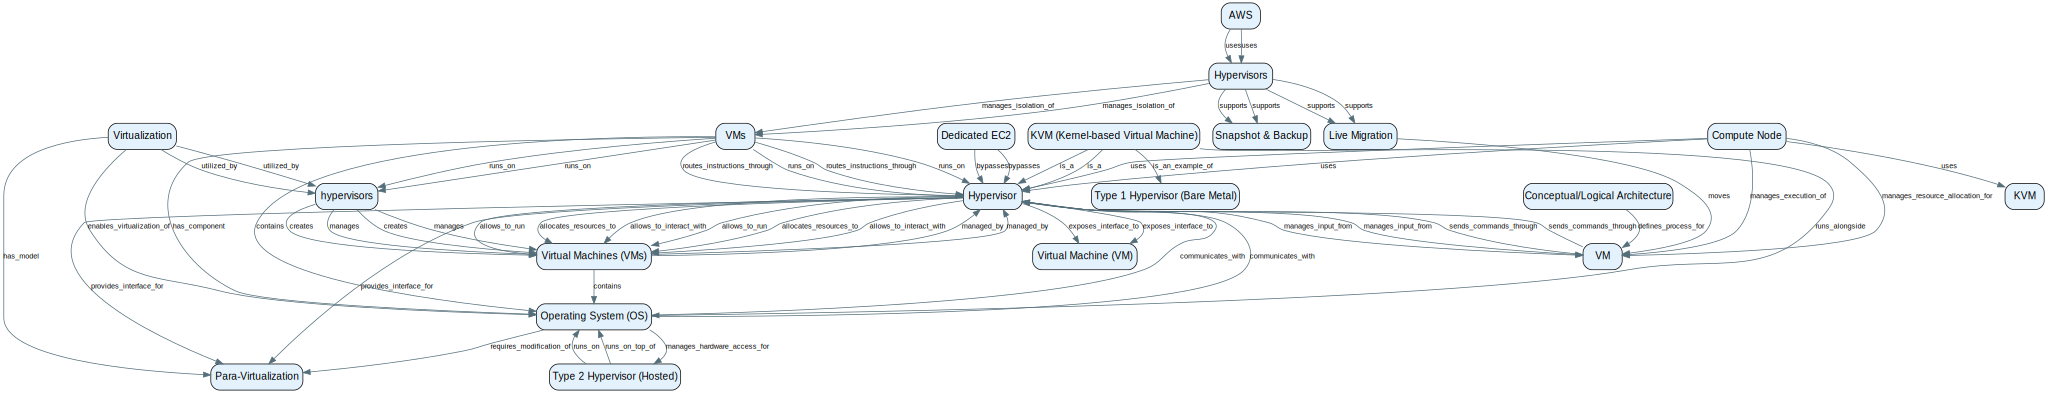

In [19]:
visualize_from_data(retrieved_entities, retrieved_connections)

## Vanilla RAG Pipeline (Baseline)
For comparison, this is our baseline Vanilla RAG. It performs the same initial vector search but does no graph traversal.

In [20]:
def vanilla_rag(query_text: str, k: int, client, gemini_client) -> str:
    """
    Performs a simple vanilla RAG retrieval.

    It finds the top-k semantically similar entities (acting as documents)
    based on the query and formats their properties into a single context string.
    This function does NOT perform any graph traversal.
    """
    # Retrieve the top K most relevant entities based on semantic similarity.
    top_entities = find_semantic_entry_points(query_text, k, client, gemini_client)

    # ormat the retrieved entities into a single context string.
    context_strings = []
    for entity in top_entities:
        context_strings.append(_format_entity_properties(entity))

    return "\n\n".join(context_strings)


We run the Vanilla RAG pipeline, retrieving 20 documents to match the context size of our Graph RAG test.

In [21]:
query = "What does a hypervisor do?"
k_documents = 20 # The number of top documents (entities) to retrieve. Here k is equivalent to the max_entities parameter in graph RAG above

vanilla_rag_context = vanilla_rag(
    query_text=query,
    k=k_documents,
    client=client,
    gemini_client=gemini_client
)

print("--- Generated Vanilla RAG Context ---")
print(vanilla_rag_context)

--- Generated Vanilla RAG Context ---
Entity: 'Hypervisor' (Class: 'Hypervisor', ID: 223)
  - definition: a software layer that allows multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.
  - key_feature: VM Process Isolation (Kernel-Level), Device Mediation & Access Control, Direct Execution of Commands from VMs
  - responsibility: Process Isolation, Resource Management, Virtual Machine Execution, Hardware Access Control

Entity: 'hypervisors' (Class: 'Hypervisor', ID: 222)
  - responsibility: create and manage virtual machines.

Entity: 'Hypervisors' (Class: 'Hypervisor', ID: 236)
  - responsibility: manage VM isolation
  - security_aspect: manage VM isolation

Entity: 'System-Level Virtualization' (Class: 'Virtualization Technology', ID: 107)
  - definition: Allows multiple operating systems to run on a single hardware system.
  - example: VirtualBox, VMware Workstation
  - type: System-Level Virtualization

Entity: 'Type 2 Hyperviso

The resulting context and the query is similarly passed to the gemini-2.5-flash to generate the response.

In [22]:
response = gemini_client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"Use the given context to answer the user's query. \nQuery: {query}, \nRetrieved Contex: {vanilla_rag_context}"
)

answer = (response.text)

print(answer)

A hypervisor is a software layer that allows multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.

Its primary functions and responsibilities include:
*   Creating and managing virtual machines.
*   Enabling multiple operating systems to run on a single hardware system.
*   Providing VM Process Isolation (managing VM isolation at the kernel level).
*   Managing resources for the virtual machines.
*   Controlling hardware access for the virtual machines.
*   Facilitating Device Mediation & Access Control.
*   Enabling the direct execution of commands from virtual machines.


I asked two separate reasoning LLMs, GPT-o3 and Gemini 2.5 Pro, to evaluate which response is better. I gave the query, response 1 (Graph RAG) and response 2 (Vanilla RAG).

# GPT o3

**Response 1 is the stronger answer.**

| Criterion                         | Response 1                                                                                          | Response 2                                                                                                                                                                                                          | Why Response 1 Wins                                            |
| --------------------------------- | --------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------- |
| **Accuracy**                      | Uses standard, widely-accepted terms: *resource management, VM isolation, hardware access control.* | Introduces fuzzy or misleading phrases such as “VM Process Isolation (…at the kernel level)” and “direct execution of commands,” which do not cleanly map to how modern hypervisors expose privileged instructions. | Avoids potentially confusing or technically imprecise wording. |
| **Completeness (core duties)**    | Lists every fundamental hypervisor responsibility most introductory texts highlight.                | Adds two extra bullets (“multiple OS on one system,” “device mediation”), but both are simply restatements or sub-cases of points already covered.                                                                  | Provides all essentials without padding.                       |
| **Clarity & Redundancy**          | Five distinct, non-overlapping bullets.                                                             | Duplicates ideas: “Creating and managing VMs” + “Enabling multiple operating systems…,” and again re-states isolation.                                                                                              | Tighter structure helps the reader grasp each point instantly. |
| **Conciseness / Signal-to-Noise** | Brief, direct, no repetition.                                                                       | Longer, with repeated concepts and an extra heading line that adds no new information.                                                                                                                              | Better signal-to-noise ratio.                                  |
| **Writing quality**               | Parallel bullet syntax, consistent verb choice, no awkward capitalization.                          | Similar style, but some bullets start with gerunds, others with nouns, and capitalization is inconsistent.                                                                                                          | More polished and professional.                                |

In short, Response 1 delivers the same substantive information in a clearer, more precise, and non-redundant manner—hallmarks of higher-quality technical writing.


# Gemini-2.5-pro

Response 1 is better.

It's more concise and clearly organized. The bullet points use **bolded** keywords to define distinct functions, making the information easier to scan and understand. Each point is a clear, separate function (Creation, Management, Execution, Control, Isolation), whereas Response 2 has some overlap and less direct points (e.g., "Enabling multiple operating systems..." is a result of what a hypervisor does, not a core function itself).

# EVALS

## Evaluation Part 1: Numerical Metrics

We'll first evaluate the two methods using standard retrieval metrics:

* **Precision@k:** Measures the fraction of retrieved items that are relevant.

$$
\text{Precision@k} = \frac{\left| \text{Retrieved} \cap \text{Golden} \right|}
                           {\left| \text{Retrieved} \right|}
$$

* **Recall@k:** Measures the fraction of relevant items that were successfully retrieved.

$$
\text{Recall@k} = \frac{\left| \text{Retrieved} \cap \text{Golden} \right|}
                       {\left| \text{Golden} \right|}
$$

* **Mean Average Precision (MAP):** The mean of Average Precision (AP) scores across all queries.  
  AP rewards ranking relevant items higher in the list.

$$
\text{AP} = \frac{\displaystyle \sum_{k=1}^{n}
                 \bigl(P(k)\,\times\,\text{rel}(k)\bigr)}
                 {\text{Number of relevant documents}}
$$

where $P(k)$ is the precision at cut-off $k$ and $\text{rel}(k)$ is 1 if the item at rank $k$ is relevant, 0 otherwise.

### Evaluation Set
We use a predefined set of 10 queries and a corresponding "golden set" of ideal entity IDs for each.

Note that we need the returned entities' entity ids from each RAG method to compute our evaluaion metrics.

In [121]:
eval_queries = [
  "How can AWS IAM policies be used to manage user access and permissions within a specific Virtual Private Cloud (VPC)?",
  "Compare the specific functions of the L3 Agent and the DHCP Agent within an OpenStack Networking Node.",
  "Explain the full lifecycle: How do Cloud-Native Applications, built on a Microservices Architecture, get deployed as Containers and then managed by an orchestration platform like Kubernetes?",
  "Why is para-virtualization, as used by the Xen hypervisor, considered to have lower overhead compared to the full virtualization approach?",
  "What is the primary use case for attaching an EBS volume, a type of block storage, to an AWS EC2 instance for persistent storage?",
  "Describe the process of a VM launch in OpenStack, detailing the roles of the Image Service, Compute Service, and the underlying KVM hypervisor.",
  "Compare the security characteristics and control levels of a Public Cloud versus a Private Cloud deployment model.",
  "How does a Multicloud strategy help an organization avoid vendor lock-in, and which cloud service providers are major players in this ecosystem?",
  "What role does middleware for 'Provisioning & Configuration' play in enabling the 'On-Demand Self-Service' characteristic of cloud computing?",
  "Explain how Open vSwitch enables software-defined networking within OpenStack by connecting virtual machines on Compute and Network nodes."
]

In [122]:
golden_ids = {
    "0": [243, 156, 170, 174, 175, 159, 160, 173, 162, 161, 164, 169, 171, 172, 48],
    "1": [182, 183, 271, 275, 180, 257, 164, 161, 187, 188, 189, 256, 274, 267, 20],
    "2": [208, 209, 238, 239, 240, 121, 127, 124, 125, 128, 129, 130, 131, 132, 122],
    "3": [117, 116, 228, 234, 224, 223, 222, 231, 225, 232, 106, 95, 118, 114, 233],
    "4": [200, 199, 203, 52, 61, 48, 190, 194, 193, 196, 205, 206, 75, 70, 197],
    "5": [260, 256, 237, 227, 274, 273, 269, 270, 254, 265, 264, 259, 261, 20, 266],
    "6": [86, 84, 92, 87, 83, 38, 36, 89, 30, 32, 33, 34, 48, 41, 42],
    "7": [90, 91, 41, 42, 43, 44, 45, 46, 48, 140, 142, 144, 145, 149, 89],
    "8": [23, 73, 21, 244, 245, 122, 261, 241, 242, 80, 75, 137, 24, 25, 140],
    "9": [180, 111, 97, 20, 270, 275, 271, 188, 181, 267, 257, 182, 183, 174, 274]
}

A function to retrieve entity ids of entities fetched and traversed using the above-defined graph RAG function.

In [123]:
def retrieve_graph_rag_ids(query_text: str, k: int, max_hops: int, max_entities: int, client, gemini_client) -> List[int]:
    """
    Runs the Graph RAG process to retrieve only the entity IDs.

    """
    # We call the modified graph_rag function to get the structured data
    _, retrieved_entities_dict, _ = graph_rag(
        query_text=query_text,
        k=k,
        max_hops=max_hops,
        max_entities=max_entities,
        client=client,
        gemini_client=gemini_client
    )
    # The keys of the entities dictionary are the unique entity IDs collected
    retrieved_ids = list(retrieved_entities_dict.keys())
    print("\nGraph RAG ids: ", retrieved_ids)
    return retrieved_ids

A function to retrieve entity ids of entities fetched using the above-defined vanilla RAG function.

In [124]:
def retrieve_vanilla_rag_ids(query_text: str, k: int, client, gemini_client) -> List[int]:
    """
    Runs the core logic of Vanilla RAG to retrieve only the entity IDs.

    """
    # find_semantic_entry_points returns a list of entity dictionaries
    retrieved_entities = find_semantic_entry_points(query_text, k, client, gemini_client)
    # Extract just the 'id' from each dictionary
    retrieved_ids = [entity.get('id') for entity in retrieved_entities if entity.get('id') is not None]
    print("\nVanilla RAG ids: ", retrieved_ids)
    return retrieved_ids

Helper functions to calculate vector search metrics.

In [125]:
def calculate_precision(retrieved: List[int], golden: List[int]) -> float:
    """Calculates precision: |retrieved & golden| / |retrieved|"""
    if not retrieved:
        return 0.0

    retrieved_set = set(retrieved)
    golden_set = set(golden)
    intersection = retrieved_set.intersection(golden_set)

    return len(intersection) / len(retrieved_set)

def calculate_recall(retrieved: List[int], golden: List[int]) -> float:
    """Calculates recall: |retrieved & golden| / |golden|"""
    if not golden:
        return 0.0

    retrieved_set = set(retrieved)
    golden_set = set(golden)
    intersection = retrieved_set.intersection(golden_set)

    return len(intersection) / len(golden_set)

def calculate_average_precision(retrieved: List[int], golden: List[int]) -> float:
    """Calculates Mean Average Precision (MAP), which rewards correct ranking."""
    if not golden:
        return 0.0

    golden_set = set(golden)
    hits = 0
    sum_of_precisions = 0.0

    for i, p in enumerate(retrieved):
        if p in golden_set:
            hits += 1
            sum_of_precisions += hits / (i + 1)

    return sum_of_precisions / len(golden_set)

Lets define a function to run our evauation. We use k = 15. This the max amount of entities to be used for evauation. This is the same as the amount of golden ids for each query in the svaluation set.
The initial k for graoh RAG is set as 5 so 1/3 entities for graph RAG are through vector search and the remaining 2/3 are fetched via graph traversal with max hops configured to 2.

In [126]:
def run_evaluation(eval_queries: List[str], golden_ids: Dict[str, List[int]], client, gemini_client):
    """
    Orchestrates the evaluation process for both Vanilla and Graph RAG.
    """
    vanilla_results = {}
    graph_results = {}

    # Define evaluation parameters
    RETRIEVAL_BUDGET = 15 # this is the k for vanilla RAG and max_entities for graph RAG
    GRAPH_RAG_K_INITIAL = 5
    GRAPH_RAG_MAX_HOPS = 2

    for i, query in enumerate(tqdm(eval_queries, desc="Evaluating Queries")):
        query_id = str(i)
        golden_set = golden_ids[query_id]

        # Evaluate Vanilla RAG
        vanilla_retrieved = retrieve_vanilla_rag_ids(query, RETRIEVAL_BUDGET, client, gemini_client)
        vanilla_results[query_id] = {
            'precision': calculate_precision(vanilla_retrieved, golden_set),
            'recall': calculate_recall(vanilla_retrieved, golden_set),
            'average_precision': calculate_average_precision(vanilla_retrieved, golden_set)
        }

        # Evaluate Graph RAG
        graph_retrieved = retrieve_graph_rag_ids(
            query,
            k=GRAPH_RAG_K_INITIAL,
            max_hops=GRAPH_RAG_MAX_HOPS,
            max_entities=RETRIEVAL_BUDGET,
            client=client,
            gemini_client=gemini_client
        )
        graph_results[query_id] = {
            'precision': calculate_precision(graph_retrieved, golden_set),
            'recall': calculate_recall(graph_retrieved, golden_set),
            'average_precision': calculate_average_precision(graph_retrieved, golden_set)
        }

    return vanilla_results, graph_results

Helper function to display the evaluation results.

In [127]:
def display_evaluation_results(vanilla_results: dict, graph_results: dict):
    """Calculates and prints the mean of the metrics in a formatted table."""

    def calculate_means(results: dict):
        num_queries = len(results)
        if num_queries == 0:
            return {'precision': 0, 'recall': 0, 'map': 0}

        mean_p = sum(res['precision'] for res in results.values()) / num_queries
        mean_r = sum(res['recall'] for res in results.values()) / num_queries
        mean_ap = sum(res['average_precision'] for res in results.values()) / num_queries

        return {'precision': mean_p, 'recall': mean_r, 'map': mean_ap}

    vanilla_means = calculate_means(vanilla_results)
    graph_means = calculate_means(graph_results)

    print("\n" + "="*50)
    print("           Retrieval Evaluation Summary")
    print("="*50)
    print(f"{'Metric':<20} | {'Vanilla RAG':<15} | {'Graph RAG':<15}")
    print("-"*50)
    print(f"{'Precision':<20} | {vanilla_means['precision']:<15.4f} | {graph_means['precision']:<15.4f}")
    print(f"{'Recall':<20} | {vanilla_means['recall']:<15.4f} | {graph_means['recall']:<15.4f}")
    print(f"{'MAP (Rank-Aware)':<20} | {vanilla_means['map']:<15.4f} | {graph_means['map']:<15.4f}")
    print("="*50)

Lets run our evals.

In [128]:
vanilla_results, graph_results = run_evaluation(eval_queries, golden_ids, client, gemini_client)
display_evaluation_results(vanilla_results, graph_results)

Evaluating Queries:   0%|          | 0/10 [00:00<?, ?it/s]


Vanilla RAG ids:  [156, 160, 159, 170, 243, 173, 149, 169, 168, 216, 161, 162, 174, 80, 165]


Evaluating Queries:  10%|█         | 1/10 [00:00<00:05,  1.52it/s]


Graph RAG ids:  [156, 160, 159, 170, 243, 141, 149, 161, 171, 172, 10, 41, 67, 80, 118]

Vanilla RAG ids:  [271, 183, 182, 20, 164, 275, 181, 257, 267, 268, 161, 188, 180, 162, 273]


Evaluating Queries:  20%|██        | 2/10 [00:01<00:04,  1.92it/s]


Graph RAG ids:  [271, 183, 182, 20, 164, 219, 237, 240, 255, 256, 258, 259, 264, 265, 266]

Vanilla RAG ids:  [121, 208, 127, 137, 209, 131, 132, 238, 129, 125, 76, 122, 138, 124, 134]


Evaluating Queries:  30%|███       | 3/10 [00:01<00:03,  2.07it/s]


Graph RAG ids:  [121, 208, 127, 137, 209, 210, 211, 212, 238, 240, 3, 13, 27, 32, 76]

Vanilla RAG ids:  [116, 117, 234, 95, 228, 96, 232, 224, 233, 107, 223, 231, 225, 106, 238]


Evaluating Queries:  40%|████      | 4/10 [00:01<00:02,  2.20it/s]


Graph RAG ids:  [116, 117, 234, 95, 228, 222, 223, 224, 235, 152, 3, 9, 17, 19, 35]

Vanilla RAG ids:  [199, 200, 194, 192, 52, 197, 193, 48, 41, 191, 170, 203, 55, 165, 201]


Evaluating Queries:  50%|█████     | 5/10 [00:02<00:02,  2.24it/s]


Graph RAG ids:  [199, 200, 194, 192, 52, 17, 41, 60, 65, 66, 79, 191, 193, 195, 196]

Vanilla RAG ids:  [256, 260, 20, 237, 274, 270, 80, 223, 69, 233, 75, 67, 259, 220, 227]


Evaluating Queries:  60%|██████    | 6/10 [00:02<00:01,  2.33it/s]


Graph RAG ids:  [256, 260, 20, 237, 274, 219, 223, 227, 240, 255, 258, 259, 262, 264, 265]

Vanilla RAG ids:  [87, 86, 92, 83, 84, 32, 30, 85, 160, 93, 89, 48, 34, 36, 75]


Evaluating Queries:  70%|███████   | 7/10 [00:03<00:01,  2.44it/s]


Graph RAG ids:  [87, 86, 92, 83, 84, 139, 41, 42, 43, 44, 45, 46, 47, 85, 89]

Vanilla RAG ids:  [90, 42, 44, 254, 142, 41, 43, 48, 45, 91, 46, 143, 49, 30, 95]


Evaluating Queries:  80%|████████  | 8/10 [00:03<00:00,  2.43it/s]


Graph RAG ids:  [90, 42, 44, 254, 142, 144, 3, 9, 32, 36, 37, 38, 74, 84, 85]

Vanilla RAG ids:  [23, 73, 72, 3, 4, 26, 21, 52, 30, 77, 41, 75, 79, 78, 71]


Evaluating Queries:  90%|█████████ | 9/10 [00:04<00:00,  2.21it/s]


Graph RAG ids:  [23, 73, 72, 3, 4, 209, 207, 264, 140, 141, 142, 143, 146, 150, 1]

Vanilla RAG ids:  [180, 20, 270, 271, 276, 275, 97, 274, 256, 257, 181, 188, 219, 182, 254]


Evaluating Queries: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Graph RAG ids:  [180, 20, 270, 271, 276, 219, 221, 237, 240, 255, 256, 257, 258, 259, 264]

           Retrieval Evaluation Summary
Metric               | Vanilla RAG     | Graph RAG      
--------------------------------------------------
Precision            | 0.6400          | 0.4267         
Recall               | 0.6400          | 0.4267         
MAP (Rank-Aware)     | 0.5726          | 0.3775         


The results show that **Vanilla RAG scores higher** on these metrics.

This is because these metrics measure simple ID overlap. Vanilla RAG's strategy is 100% optimized for this (retrieving the top 15 most similar items through pure vector search), while Graph RAG's strategy involves exploring structurally-related nodes that may be less semantically similar, thus lowering its overlap score. This highlights the limitations of using these metrics alone to judge the *utility* of a retrieved context.
These metrics also do not reflect the cost and speed optimisation provided by graph traversal over vector search.

## Evaluation Part 2: LLM-as-a-Judge

Given the limitations of numerical metrics, we'll use a more qualitative approach. An LLM-as-a-Judge will evaluate the **quality of the final generated answer** from each RAG method. This better reflects the true performance of the system.

**The Process:**
1.  Generate an answer using the Vanilla RAG context.
2.  Generate an answer using the Graph RAG context.
3.  Have a powerful reasoning LLM act as a judge and vote for the better answer.

For the answer generation, we use [`gemini-2.5-flash`](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash), whereas [`gemini-2.5-pro`](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro) is best-suited to be the judge.

For the answer generation, the LLM is simple provided the query + the retrieved context and is prompted to generate the answer based solely on that context.

The judge LLM is instructed to only respond with the choice 1 (for vanilla RAG response preference) or 2 (for graph RAG response preference).

In [97]:
def generate_answer(query: str, context: str, generator_client) -> str:
    """
    Generates an answer to a query using the provided context.
    Uses the gemini-2.5-flash model for speed and efficiency.
    """
    prompt = (
        "Based only on the provided context, answer the following query concisely. "
        "If the context does not contain the answer, state that you cannot answer based on the information given.\n\n"
        f"Query: {query}\n\n"
        f"Context:\n{context}\n\n"
        "Answer:"
    )

    try:
        # Use the gemini_client already initialized
        response = generator_client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )
        print(response.text)
        return response.text
    except Exception as e:
        print(f"An error occurred during answer generation: {e}")
        return "Error: Could not generate an answer."

def judge_answers(query: str, answer_1: str, answer_2: str, judge_client) -> int:
    """
    Asks a powerful LLM judge to decide which of two answers is better.
    Uses gemini-2.5-pro for its strong reasoning capabilities.
    Returns 1 for Answer 1 or 2 for Answer 2.
    """
    prompt = (
        "You are an impartial judge. Your task is to evaluate two AI-generated answers to a user's query and determine which is better. "
        "Consider correctness, completeness, and clarity.\n\n"
        f"USER QUERY:\n'{query}'\n\n"
        "--- ANSWER 1 ---\n"
        f"{answer_1}\n\n"
        "--- ANSWER 2 ---\n"
        f"{answer_2}\n\n"
        "--- INSTRUCTIONS ---\n"
        "Output only the number of the better answer: '1' or '2'."
    )

    try:
        # Use the gemini_client for the judge model
        response = judge_client.models.generate_content(
            model="gemini-2.5-pro",
            contents=prompt
        )

        # Parse the last line of the response to get the deterministic vote
        last_line = response.text.strip().split('\n')[-1].strip()
        if last_line == "1":
            return 1
        elif last_line == "2":
            return 2
        else:
            # If the model fails to follow instructions, default to 0.
            return 0
    except Exception as e:
        print(f"An error occurred during judging: {e}")
        return 0 # Return 0 for error

We define the orchestration function to run the LLM-as-a-Judge evals.

In [98]:
def run_llm_as_judge_evaluation(eval_queries: List[str], client, gemini_client):
    """
    Orchestrates the end-to-end evaluation using an LLM-as-a-Judge.
    """
    scores = {"vanilla_wins": 0, "graph_wins": 0, "errors": 0}

    # Define RAG parameters for this evaluation ---
    VANILLA_K = 15
    GRAPH_K_INITIAL = 5
    GRAPH_MAX_HOPS = 2
    GRAPH_MAX_ENTITIES = 15

    print("--- Starting LLM-as-a-Judge Evaluation ---")

    for query in tqdm(eval_queries, desc="Judging Queries"):
        # Get contexts from both RAG methods
        vanilla_context = vanilla_rag(query, VANILLA_K, client, gemini_client)
        graph_context, _, _ = graph_rag(
            query, GRAPH_K_INITIAL, GRAPH_MAX_HOPS, GRAPH_MAX_ENTITIES, client, gemini_client
        )

        # Generate an answer for each context
        print(f"\nGenerating answers for query: '{query[:50]}...'")
        answer_vanilla = generate_answer(query, vanilla_context, gemini_client)
        answer_graph = generate_answer(query, graph_context, gemini_client)

        # Have the judge decide which answer is better
        vote = judge_answers(query, answer_vanilla, answer_graph, gemini_client)

        # Tally the votes
        if vote == 1:
            scores["vanilla_wins"] += 1
            print(">> Judge voted for: Vanilla RAG")
        elif vote == 2:
            scores["graph_wins"] += 1
            print(">> Judge voted for: Graph RAG")
        else:
            scores["errors"] += 1
            print(">> Failed to vote.")

    print("\n--- LLM-as-a-Judge Evaluation Complete ---")
    return scores


Helper function to display theresults of the LLM-as-a-Judge evals.

In [108]:
def display_judge_results(scores: dict):
    """Prints the final scorecard from the LLM-as-a-Judge evaluation."""
    total_queries = sum(scores.values())

    print("\n" + "="*50)
    print("           LLM-as-a-Judge Final Scorecard")
    print("="*50)
    print(f"Total Queries Judged: {total_queries}")
    print(f"Vanilla RAG Wins:     {scores['vanilla_wins']}")
    print(f"Graph RAG Wins:       {scores['graph_wins']}")
    print(f"Errors:       {scores['errors']}")
    print("="*50)

    if scores['graph_wins'] > scores['vanilla_wins']:
        print("\nVerdict: Graph RAG produced higher-quality answers.")
    elif scores['vanilla_wins'] > scores['graph_wins']:
        print("\nVerdict: Vanilla RAG produced higher-quality answers.")
    else:
        print("\nVerdict: It's a tie!")

Lets run the evals and collect the scores.

In [111]:
judge_scores = run_llm_as_judge_evaluation(eval_queries, client, gemini_client)

--- Starting LLM-as-a-Judge Evaluation ---


Judging Queries:   0%|          | 0/10 [00:00<?, ?it/s]


Generating answers for query: 'How can AWS IAM policies be used to manage user ac...'
The provided context states that 'Identity & Access Management (IAM)' (ID: 243) "Manages user roles and authentication" for AWS. It also describes 'Virtual Private Cloud (VPC)' (ID: 156, 170) as a logically isolated section within AWS. However, the context does not provide specific details on how AWS IAM policies are used to manage user access and permissions *within* a specific Virtual Private Cloud (VPC).
I cannot answer based on the information given. The context states that 'Identity & Access Management (IAM)' manages user roles and authentication for AWS, and that 'Access Controls' and 'Network Policies' ensure isolation within a VPC, but it does not explain how AWS IAM policies specifically manage user access and permissions within a VPC.


Judging Queries:  10%|█         | 1/10 [00:19<02:59, 19.90s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'Compare the specific functions of the L3 Agent and...'
The L3 Agent connects cloud machines to the external world and provides routing, while the DHCP Agent assigns IP addresses dynamically. Both are components of an OpenStack Networking Node.
Within an OpenStack Networking Node:
*   The **L3 Agent** connects cloud machines to the external world and provides routing.
*   The **DHCP Agent** dynamically assigns IP addresses.


Judging Queries:  20%|██        | 2/10 [00:33<02:10, 16.29s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Explain the full lifecycle: How do Cloud-Native Ap...'
Cloud-Native Applications (CNA) are designed specifically for cloud environments and are built using a Microservices Architecture, meaning applications are split into small, independent services. These services are packaged into Containers, which are lightweight, provide an isolated environment, and share the host OS kernel. Containers are then deployed as Pods, which are the smallest deployable units in Kubernetes and can contain one or more containers.

Kubernetes, as a container orchestration platform, manages and scales these containers across multiple machines. The Control Plane manages and schedules these containerized workloads across the Worker Nodes, which run the actual workloads. Key components like the Controller Manager maintain the state of Kubernetes objects, Kube-proxy manages network communication between pods, and etcd provides persistent storage for co

Judging Queries:  30%|███       | 3/10 [00:55<02:12, 18.89s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'Why is para-virtualization, as used by the Xen hyp...'
The context states that Full Virtualization has "Higher overhead due to full emulation," and Para-Virtualization has "Performance optimization due to lower overhead." However, the context does not provide the specific reason *why* para-virtualization has lower overhead compared to full virtualization.
Para-virtualization has lower overhead because the hypervisor provides a specialized interface that does not exist in physical hardware. In contrast, full virtualization has higher overhead due to full emulation, as its hypervisor exposes the same hardware interface as physical hardware.


Judging Queries:  40%|████      | 4/10 [01:11<01:45, 17.63s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'What is the primary use case for attaching an EBS ...'
The primary use case for attaching an EBS volume, a type of block storage, to an AWS EC2 instance is for persistent storage on EC2 instances.
The primary use case for attaching an EBS volume, a type of block storage, to an AWS EC2 instance is for persistent storage.


Judging Queries:  50%|█████     | 5/10 [01:23<01:17, 15.56s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Describe the process of a VM launch in OpenStack, ...'
Based only on the provided context, the detailed process of a VM launch in OpenStack is not described. However, the roles of the specified services in the context of VM management are as follows:

*   **Image Service**: Handles the creation and management of VM images, which would be used as the base for launching a VM.
*   **Compute Service**: Manages the overall VM lifecycle, including making VM scheduling decisions and distributing resources across machines. It is the service responsible for launching and managing VMs, and it utilizes KVM as its default hypervisor.
*   **KVM Hypervisor**: Runs virtual machines on a single physical machine by abstracting hardware resources. It is the default hypervisor used by OpenStack's Compute Service and is responsible for virtual machine execution, process isolation, resource management, and hardware access control on the Compute 

Judging Queries:  60%|██████    | 6/10 [01:56<01:26, 21.58s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Compare the security characteristics and control l...'
Private Cloud offers more control and more security. For Public Cloud, security can be a concern; its control level is not explicitly detailed in the context for direct comparison.
**Security Characteristics:**
*   **Private Cloud:** Offers "More security."
*   **Public Cloud:** "Security can be a concern."

**Control Levels:**
*   **Private Cloud:** Provides "More control."
*   The context does not specify the control level for Public Cloud.


Judging Queries:  70%|███████   | 7/10 [02:16<01:03, 21.03s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'How does a Multicloud strategy help an organizatio...'
A Multicloud strategy helps an organization avoid vendor lock-in by utilizing services from multiple cloud providers.

Major cloud service providers mentioned in the context that are major players in this ecosystem include AWS (Amazon Web Services), Azure (Microsoft Azure), GCP (Google Cloud), and IBM Cloud.
A Multicloud strategy helps an organization avoid vendor lock-in by utilizing services from multiple cloud providers. The context identifies GCP and IBM Cloud as major companies that hold a significant portion of cloud infrastructure.


Judging Queries:  80%|████████  | 8/10 [02:30<00:37, 18.85s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'What role does middleware for 'Provisioning & Conf...'
Middleware for 'Provisioning & Configuration' helps in cloud deployment and workload management, which enables the 'On-Demand Self-Service' characteristic by allowing users to configure and deploy services independently without human intervention.
The provided context states that 'Provisioning & Configuration' middleware "Helps in cloud deployment and workload management." It also states that 'On-Demand Self-Service' means "Users can configure and deploy services independently, without requiring human intervention." However, the context does not explicitly explain the specific role 'Provisioning & Configuration' middleware plays in *enabling* the 'On-Demand Self-Service' characteristic beyond its general function of helping with cloud deployment.


Judging Queries:  90%|█████████ | 9/10 [02:45<00:17, 17.75s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'Explain how Open vSwitch enables software-defined ...'
The context states that Open vSwitch "Enables software-defined networking (SDN) in OpenStack" and "Allows unlimited VMs to connect". It also notes that Open vSwitch is a component of both "Compute Nodes" and "Network Nodes". However, the provided context does not explain *how* Open vSwitch connects virtual machines on these nodes to enable SDN.
Open vSwitch enables software-defined networking (SDN) in OpenStack as a software-based network switch. It is a component on both Compute Nodes and Network Nodes, and allows unlimited virtual machines (VMs) to connect. However, the provided context does not explain the specific mechanism of how Open vSwitch connects virtual machines *between* Compute and Network nodes to enable SDN.


Judging Queries: 100%|██████████| 10/10 [03:05<00:00, 18.59s/it]

>> Judge voted for: Graph RAG

--- LLM-as-a-Judge Evaluation Complete ---


The moment of truth - lets display the results.

In [112]:
display_judge_results(judge_scores)


           LLM-as-a-Judge Final Scorecard
Total Queries Judged: 10
Vanilla RAG Wins:     4
Graph RAG Wins:       6
Errors:       0

Verdict: Graph RAG produced higher-quality answers.


The final scorecard shows that **Graph RAG is the winner.**

This result demonstrates that while its retrieved context had less direct overlap with the golden set, the structure and rich connections within that context enabled the generator LLM to produce superior, more helpful answers. This confirms the value of Graph RAG in a way that the numerical metrics could not.